<a href="https://colab.research.google.com/github/TreasureSam/IBM-Granite/blob/main/notebooks/Granite_Multimodal_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building an AI-powered multimodal RAG system with Docling and Granite

*Using IBM Granite vision, text-based embeddings and generative AI models*

## Multimodal retrieval-augmented generation

[Retrieval-augmented generation (RAG)](https://www.ibm.com/think/topics/retrieval-augmented-generation) is a technique used with large language models (LLMs) to connect the model with a knowledge base of information outside the data the LLM has been trained on without having to perform [fine-tuning](https://www.ibm.com/think/topics/rag-vs-fine-tuning). Traditional RAG is limited to text-based use cases such as text summarization and chatbots.

Multimodal RAG can use [multimodal](https://www.ibm.com/think/topics/multimodal-ai) LLMs (MLLM) to process information from multiple types of data to be included as part of the external knowledge base used in RAG. Multimodal data can include text, images, audio, video or other forms. Popular multimodal LLMs include Google’s Gemini, Meta’s Llama 3.2 and OpenAI’s GPT-4 and GPT-4o.

For this recipe, you will use an IBM Granite model capable of processing different modalities. You will create an AI system to answer real-time user queries from unstructured data in a PDF.

## Recipe overview

Welcome to this Granite recipe. In this recipe, you'll learn how to harness the power of advanced tools to build an AI-powered multimodal RAG pipeline. This tutorial will guide you through the following processes:

- **Document preprocessing:** Learn how to handle documents from various sources, parse and transform them into usable formats and store them in vector databases by using Docling. You will use a Granite MLLM to generate image descriptions of images in the documents.
- **RAG:** Understand how to connect LLMs such as Granite with external knowledge bases to enhance query responses and generate valuable insights.
- **LangChain for workflow integration:** Discover how to use LangChain to streamline and orchestrate document processing and retrieval workflows, enabling seamless interaction between different components of the system.

This recipe uses three cutting-edge technologies:

1. **[Docling](https://docling-project.github.io/docling/):** An open-source toolkit used to parse and convert documents.
2. **[Granite](https://www.ibm.com/granite/docs/models/granite/):** A state-of-the-art LLM that provides robust natural language capabilities and a vision language model that provides image to text generation.
3. **[LangChain](https://github.com/langchain-ai/langchain):** A powerful framework used to build applications powered by language models, designed to simplify complex workflows and integrate external tools seamlessly.

By the end of this recipe, you will accomplish the following:
- Gain proficiency in document preprocessing, chunking and image understanding.
- Integrate vector databases to enhance retrieval capabilities.
- Use RAG to perform efficient and accurate data retrieval for real-world applications.

This recipe is designed for AI developers, researchers and enthusiasts looking to enhance their knowledge of document management and advanced natural language processing (NLP) techniques.


## Prerequisites

- Familiarity with Python programming.
- Basic understanding of LLMs, NLP concepts and computer vision.

## Step 1: Setting up the environment

Ensure you are running Python 3.10, 3.11 or 3.12 in a freshly created virtual environment.

In [1]:
import sys
assert sys.version_info >= (3, 10) and sys.version_info < (3, 13), "Use Python 3.10, 3.11, or 3.12 to run this notebook."

## Step 2: Install dependencies

In [2]:
! pip install "git+https://github.com/ibm-granite-community/utils.git" \
    transformers \
    pillow \
    langchain_community \
    langchain_huggingface \
    langchain_milvus \
    docling \
    replicate

  Cloning https://github.com/ibm-granite-community/utils.git to /tmp/pip-req-build-1netn114
  Running command git clone --filter=blob:none --quiet https://github.com/ibm-granite-community/utils.git /tmp/pip-req-build-1netn114
  Resolved https://github.com/ibm-granite-community/utils.git to commit 157a188d350c6220679f40106a20d7c230e9b61d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.9/178.9 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.3/151.3 kB 11.5 MB/s eta 0:00:00
   ━━━

## Step 3: Selecting the AI models

### Logging

To see some logging information, we can configure INFO log level.

NOTE: It is okay to skip running this cell.

In [3]:
import logging

logging.basicConfig(level=logging.INFO)

### Load the Granite models

Specify the embeddings model to use for generating text embedding vectors. Here we will use one of the [Granite Embeddings models](https://huggingface.co/collections/ibm-granite/granite-embedding-models-6750b30c802c1926a35550bb)

To use a different embeddings model, replace this code cell with one from [this Embeddings Model recipe](https://github.com/ibm-granite-community/granite-kitchen/blob/main/recipes/Components/Langchain_Embeddings_Models.ipynb).

In [4]:
from langchain_huggingface import HuggingFaceEmbeddings
from transformers import AutoTokenizer

embeddings_model_path = "ibm-granite/granite-embedding-30m-english"
embeddings_model = HuggingFaceEmbeddings(
    model_name=embeddings_model_path,
)
embeddings_tokenizer = AutoTokenizer.from_pretrained(embeddings_model_path)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/467k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/683 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/60.6M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Specify the MLLM to use for image understanding. We will use the Granite vision model.

In [5]:
from ibm_granite_community.notebook_utils import get_env_var
from langchain_community.llms import Replicate
from transformers import AutoProcessor

vision_model_path = "ibm-granite/granite-vision-3.2-2b"
vision_model = Replicate(
    model=vision_model_path,
    replicate_api_token=get_env_var("REPLICATE_API_TOKEN"),
    model_kwargs={
        "max_tokens": embeddings_tokenizer.max_len_single_sentence, # Set the maximum number of tokens to generate as output.
        "min_tokens": 100, # Set the minimum number of tokens to generate as output.
    },
)
vision_processor = AutoProcessor.from_pretrained(vision_model_path)

REPLICATE_API_TOKEN not found in Google Colab secrets.
Please enter your REPLICATE_API_TOKEN: ··········


processor_config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/2.05k [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/6.97k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/777k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/442k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.06M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

Specify the language model to use for the RAG generation operation. Here we use the Replicate LangChain client to connect to a Granite model from the [`ibm-granite`](https://replicate.com/ibm-granite) org on Replicate.

To get set up with Replicate, see [Getting Started with Replicate](https://github.com/ibm-granite-community/granite-kitchen/blob/main/recipes/Getting_Started/Getting_Started_with_Replicate.ipynb).

To connect to a model on a provider other than Replicate, substitute this code cell with one from the [LLM component recipe](https://github.com/ibm-granite-community/granite-kitchen/blob/main/recipes/Components/Langchain_LLMs.ipynb).

In [6]:
model_path = "ibm-granite/granite-3.3-8b-instruct"
model = Replicate(
    model=model_path,
    replicate_api_token=get_env_var("REPLICATE_API_TOKEN"),
    model_kwargs={
        "max_tokens": 1000, # Set the maximum number of tokens to generate as output.
        "min_tokens": 100, # Set the minimum number of tokens to generate as output.
    },
)
tokenizer = AutoTokenizer.from_pretrained(model_path)

tokenizer_config.json:   0%|          | 0.00/9.93k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/777k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/442k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.48M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/207 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/801 [00:00<?, ?B/s]

## Step 4: Preparing the documents for the vector database

In this example, from a set of source documents, we use [Docling](https://docling-project.github.io/docling/) to convert the documents into text and images. The text is then split into chunks. The images are processed by the MLLM to generate image summaries.

### Use Docling to download the documents and convert to text and images

Docling will download the PDF documents and process them so we can obtain the text and images the documents contain. In the PDF, there are various data types, including text, tables, graphs and images.

In [7]:
from docling.document_converter import DocumentConverter, PdfFormatOption
from docling.datamodel.base_models import InputFormat
from docling.datamodel.pipeline_options import PdfPipelineOptions

pdf_pipeline_options = PdfPipelineOptions(
    do_ocr=False,
    generate_picture_images=True,
)
format_options = {
    InputFormat.PDF: PdfFormatOption(pipeline_options=pdf_pipeline_options),
}
converter = DocumentConverter(format_options=format_options)

sources = [
    "https://midwestfoodbank.org/images/AR_2020_WEB2.pdf",
]
conversions = { source: converter.convert(source=source).document for source in sources }

With the documents processed, we then further process the text elements in the documents. We chunk them into appropriate sizes for the embeddings model we are using. A list of LangChain documents are created from the text chunks.

In [8]:
from docling_core.transforms.chunker.hybrid_chunker import HybridChunker
from docling_core.types.doc.document import TableItem
from langchain_core.documents import Document

doc_id = 0
texts: list[Document] = []
for source, docling_document in conversions.items():
    for chunk in HybridChunker(tokenizer=embeddings_tokenizer).chunk(docling_document):
        items = chunk.meta.doc_items
        if len(items) == 1 and isinstance(items[0], TableItem):
            continue # we will process tables later
        refs = " ".join(map(lambda item: item.get_ref().cref, items))
        print(refs)
        text = chunk.text
        document = Document(
            page_content=text,
            metadata={
                "doc_id": (doc_id:=doc_id+1),
                "source": source,
                "ref": refs,
            },
        )
        texts.append(document)

print(f"{len(texts)} text document chunks created")

Token indices sequence length is longer than the specified maximum sequence length for this model (669 > 512). Running this sequence through the model will result in indexing errors


#/texts/1
#/texts/4 #/texts/5
#/texts/7 #/texts/8 #/texts/9 #/texts/10 #/texts/11 #/texts/12 #/texts/13
#/tables/0 #/texts/16 #/texts/17
#/texts/20
#/texts/22
#/texts/24
#/texts/26
#/texts/28
#/texts/30
#/texts/32
#/texts/34
#/texts/40 #/texts/41
#/texts/44
#/texts/46 #/texts/47 #/texts/48 #/texts/49 #/texts/50 #/texts/51 #/texts/52 #/texts/53 #/texts/54
#/texts/56
#/texts/58 #/texts/59 #/texts/60 #/texts/61 #/texts/62 #/texts/63
#/texts/177 #/texts/178
#/tables/1 #/texts/182 #/texts/190
#/texts/194 #/texts/195
#/texts/197 #/texts/198 #/texts/199
#/texts/203 #/texts/204 #/texts/205 #/texts/206
#/texts/208 #/texts/209 #/texts/210 #/texts/211 #/texts/212 #/texts/213 #/texts/214 #/texts/215 #/texts/216
#/texts/227
#/texts/229 #/texts/230 #/texts/231 #/texts/232 #/texts/233
#/texts/236
#/texts/238
#/texts/240
#/texts/242
#/texts/244
#/texts/246
#/texts/248
#/texts/250
#/texts/252
#/texts/254
#/texts/256
#/texts/258
#/texts/260
#/texts/267 #/texts/268 #/texts/269
#/texts/271 #/texts/272
#/t

Next we process any tables in the documents. We convert the table data to markdown format for passing into the language model. A list of LangChain documents are created from the table's markdown renderings.

In [9]:
from docling_core.types.doc.labels import DocItemLabel

doc_id = len(texts)
tables: list[Document] = []
for source, docling_document in conversions.items():
    for table in docling_document.tables:
        if table.label in [DocItemLabel.TABLE]:
            ref = table.get_ref().cref
            print(ref)
            text = table.export_to_markdown(docling_document)
            document = Document(
                page_content=text,
                metadata={
                    "doc_id": (doc_id:=doc_id+1),
                    "source": source,
                    "ref": ref
                },
            )
            tables.append(document)


print(f"{len(tables)} table documents created")

#/tables/1
1 table documents created


Finally we process any images in the documents. Here we use the vision language model to understand the content of an image. In this example, we are interested in any textual information in the image. You might want to experiment with different prompt text to see how it might improve the results.

NOTE: Processing the images can take a very long time depending upon the number of images and the service running the vision language model.

In [10]:
import base64
import io
import PIL.Image
import PIL.ImageOps

def encode_image(image: PIL.Image.Image, format: str = "png") -> str:
    image = PIL.ImageOps.exif_transpose(image) or image
    image = image.convert("RGB")

    buffer = io.BytesIO()
    image.save(buffer, format)
    encoding = base64.b64encode(buffer.getvalue()).decode("utf-8")
    uri = f"data:image/{format};base64,{encoding}"
    return uri

# Feel free to experiment with this prompt
image_prompt = "If the image contains text, explain the text in the image."
conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": image_prompt},
        ],
    },
]
vision_prompt = vision_processor.apply_chat_template(
    conversation=conversation,
    add_generation_prompt=True,
)
pictures: list[Document] = []
doc_id = len(texts) + len(tables)
for source, docling_document in conversions.items():
    for picture in docling_document.pictures:
        ref = picture.get_ref().cref
        print(ref)
        image = picture.get_image(docling_document)
        if image:
            text = vision_model.invoke(vision_prompt, image=encode_image(image))
            document = Document(
                page_content=text,
                metadata={
                    "doc_id": (doc_id:=doc_id+1),
                    "source": source,
                    "ref": ref,
                },
            )
            pictures.append(document)

print(f"{len(pictures)} image descriptions created")

#/pictures/0
#/pictures/1
#/pictures/2
#/pictures/3
#/pictures/4
#/pictures/5
#/pictures/6
#/pictures/7
#/pictures/8
#/pictures/9
#/pictures/10
#/pictures/11
#/pictures/12
#/pictures/13
#/pictures/14
#/pictures/15
#/pictures/16
#/pictures/17
#/pictures/18
#/pictures/19
#/pictures/20
#/pictures/21
#/pictures/22
#/pictures/23
#/pictures/24
#/pictures/25
#/pictures/26
#/pictures/27
#/pictures/28
#/pictures/29
#/pictures/30
#/pictures/31
#/pictures/32
#/pictures/33
#/pictures/34
#/pictures/35
#/pictures/36
#/pictures/37
#/pictures/38
#/pictures/39
#/pictures/40
#/pictures/41
#/pictures/42
#/pictures/43
#/pictures/44
#/pictures/45
#/pictures/46
#/pictures/47
#/pictures/48
#/pictures/49
#/pictures/50
#/pictures/51
#/pictures/52
#/pictures/53
54 image descriptions created


We can then display the LangChain documents created from the input documents.

Document ID: 1
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
bridging the gap between poverty and prosperity
Document ID: 2
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
No one could have predicted the events of 2020. The global COVID-19 pandemic created a dynamic year. With the help of volunteers, donors, staff, and most importantly, the blessings of God, Midwest Food Bank responded nimbly to the changing landscape.
All  MFB  locations  remained  open  and  responsive  to  the  need  of  our nonprofit partners. We enacted safety protocols and reduced volunteer numbers  to  maintain  social  distancing  guidelines.  To  allow  partner agencies to receive food from MFB safely, we altered our distribution model.  Community,  business,  and  donor  support  funded  operations and helped with food purchases. More details on our response to the pandemic are on page 14.
Document ID: 3
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Co

Document ID: 76
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is "Midwest Food Bank," which is likely the name of an organization or institution. The text is presented in a straightforward, sans-serif font, which is often used for its readability and modern appearance. The choice of a sans-serif font along with the bold, capitalized lettering suggests that the organization aims to be perceived as modern, accessible, and authoritative. The use of the word "Midwest" indicates that the organization is based in or serves the Midwest region of the United States. The design of the logo is simple and clear, which is effective for branding and identification purposes.
Image:


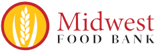

Document ID: 77
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The image contains the text "KEEP MOVING FORWARD". This phrase is often used to motivate individuals to continue working towards their goals despite challenges or setbacks. It serves as a reminder to persevere and not give up. The text is clear and legible, with a simple, bold font that ensures the message is immediately understood. There are no other discernible texts or graphics in the image.
Image:


Document ID: 78
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The image does not contain any text. It is a photograph of a person with no visible words or phrases that convey a message or provide context. The design of the image focuses on the person and their smile, which could imply a positive or celebratory context, but without text, the exact message remains ambiguous.
Image:


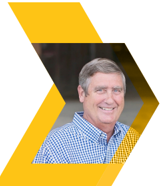

Document ID: 79
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The image provided does not contain any text. The focus is on the individuals and their actions, which are related to food donation. The absence of text allows the viewer to concentrate on the human element and the context of the scene, which is a charitable activity, possibly part of a food bank or a similar organization's operations. The image does not include any discernible text that provides additional information about the location, the nature of the donation, or the specific organization involved.
Image:


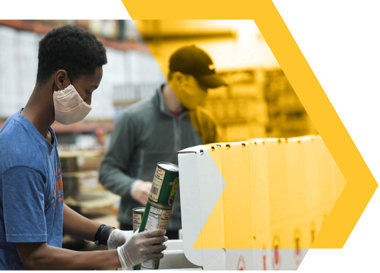

Document ID: 80
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The image contains text that represents the logos of three popular social media platforms: Facebook (f), Instagram (i), and LinkedIn (n). These logos are widely recognized icons used to identify these platforms on websites and in applications. The text is not discernible due to the blurred quality of the image, but the logos themselves are clear and distinctive symbols associated with their respective social media services.
Image:


Document ID: 81
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is partially obscured, making it challenging to provide a complete transcription. However, we can infer that the text is likely related to the organization or the context in which the photograph was taken. The visible words "Midw" and "FOOD BA" suggest that the text could be part of a larger phrase or name, possibly indicating the name of a food bank organization or a specific program or initiative. Without the full visibility of the text, it is not possible to accurately determine the exact content of the text. If the full text were visible, it could provide context about the organization's mission, the nature of the work being done, or the location and purpose of the food bank's operations.
Image:


Document ID: 82
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The image provided is a graphic icon and does not contain any text. Icons are typically used to represent actions, objects, or ideas in a visual format and are often designed to be simple and easily recognizable. This particular icon, with its hands, is commonly used to symbolize assistance, support, or help, and it could be part of an application or a user interface that deals with themes of care, service, or community. Without text, the icon communicates its message through universally understood visual symbols, which is a key aspect of effective iconography.
Image:


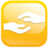

Document ID: 83
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The image provided does not contain any text. It is a graphical icon that appears to represent a person with arms raised in a gesture that could be associated with success, victory, or the act of reaching out. The design is minimalistic and uses a gradient of red and white to create a sense of depth and dimension. There is no additional text present in the image to convey any message beyond the icon's visual representation.
Image:


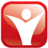

Document ID: 84
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The image does not contain any text. It is a simple, stylized icon with no accompanying text to provide information or context. The design is abstract, and the use of the dot pattern could be interpreted in various ways, depending on the viewer's perspective. Without additional context or information, it is not possible to determine any specific meaning or text that might be present in the image.
Image:


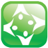

Document ID: 85
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The image provided is a simplified icon of a shield, which typically symbolizes protection, security, or defense. It does not contain any text. In the context of an icon, text would usually provide additional information or context, but since this icon is devoid of any text, it serves as a standalone symbol without any accompanying textual information.
Image:


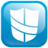

Document ID: 86
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The image does not contain any text. It is a simple icon featuring two hands that appear to be in a gesture of unity or solidarity. The hands are positioned in a way that suggests a coming together or a meeting point, which is often used to represent concepts such as collaboration, teamwork, or partnership. There is no accompanying text to provide additional context or information about the icon's purpose or the message it intends to convey.
Image:


Document ID: 87
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is not clear due to the resolution and angle of the photograph. It appears to be a label or tag attached to the cardboard boxes, which is common in warehouse settings for inventory and tracking purposes. The text is too small to read in detail from this image. It is likely to contain information such as the contents of the boxes, shipping information, or a reference number for the items. Without clearer text, it is not possible to provide specific details about the text in the image.
Image:


Document ID: 88
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is partially obscured and not fully legible. However, from what is visible, it appears to be a fragment of a larger word or phrase. The visible letters "Y" and "e" suggest that the text could be part of a word like "Yes" or "you." Without the full context or additional letters, it is not possible to accurately determine the complete text. If the text is intended to convey a message or a brand name, it would require more information or a clearer view to provide an accurate explanation.
Image:


Document ID: 89
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image reads "bathpan Hope." This text is likely a caption or a tag that could be associated with the image, possibly indicating the name of a brand, a product, or a specific line of bathroom accessories. Without additional context, it is not possible to determine the exact meaning or significance of the text. It could be a part of a marketing campaign, a branding element, or a personal message. The presence of the text suggests that the image may be used in a commercial or promotional setting, where the brand or product name is being highlighted.
Image:


Document ID: 90
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The image contains no text.
Image:


Document ID: 91
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is partially obscured and not entirely legible. However, it appears to be a logo or a name, which could be related to a brand, organization, or team. Due to the angle and the partial view, the specific content of the text cannot be determined from the image provided. To accurately explain the text, one would need a clearer view or additional information about the context in which the image was taken.
Image:


Document ID: 92
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image reads "BERLINDA," which could be a name or a title. There is also a partial view of text that seems to read "a bout da," which might be a part of a phrase or a name. Without additional context, it's not possible to determine the full meaning or purpose of the text in the image.
Image:


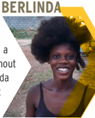

Document ID: 93
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The image contains text that appears to be a list of various programs or initiatives that are related to donations and financial support. The text is not fully legible, but it seems to be listing different types of aid or programs that are supported by donations, such as food pantries, disaster relief, and tender mercies. These are typically programs that provide assistance to those in need, often in response to natural disasters or other crises. The presence of these icons and text suggests that the image is part of an informational or educational material explaining how donations can be used to support such programs.
Image:


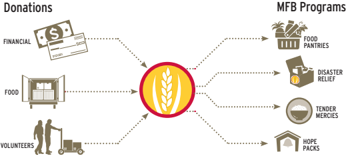

Document ID: 94
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image provides context and information about the graph. It states that the graph represents sustainable growth in the number of Midwest Food Bank locations and the value of food distributed. This indicates that the graph is tracking the expansion and impact of food bank services in the Midwest region over time. The mention of "PENNSYLVANIA NEW ENGLAND" suggests that the data is specific to these two states within the Midwest. The presence of specific states implies that the graph may be comparing the growth trends in these areas or highlighting the relative performance of food banks in these states.
Image:


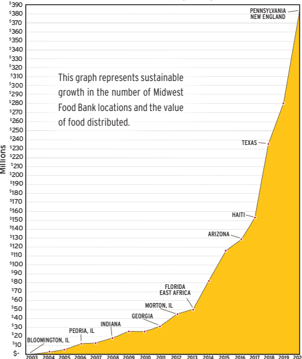

Document ID: 95
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is "FINANCIALS". This term is typically associated with financial statements, which are documents that summarize a company's financial performance over a specific period. These statements are used by investors, creditors, and analysts to assess a company's financial health and to make informed decisions about investments or loans. The term "financials" is often used in the context of accounting and finance to refer to the specific area of a company's financial information.
Image:


Document ID: 96
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The image contains text that appears to be a comparative statement. It states that $13 million was spent and $383 million was yielded from food distribution. This suggests a high level of efficiency or impact in the distribution of food, where the yield far exceeds the expenditure. The text is likely used to highlight the effectiveness of a food distribution program or campaign.
Image:


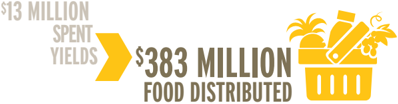

Document ID: 97
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The image contains text that is not fully legible due to the angle and the resolution. However, it appears to be a label or a brand name, possibly related to the products being handled or the company operating the warehouse. The text is likely to provide information about the contents of the boxes or the company's identity. Without a clearer view or additional context, it is not possible to provide a detailed explanation of the text. If you need more information about the text, it would be best to either view the image in higher resolution or provide more context about the setting and the products being handled.
Image:


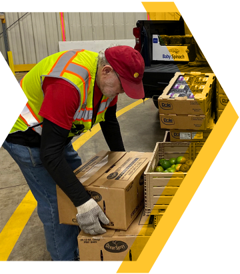

Document ID: 98
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is part of the branding for the Midwest Food Bank. It reads "Midwest Food Bank" and "Sharing the Blessings," which is the organization's name and slogan, respectively. The text is prominently displayed on the side of the cardboard boxes, which are being filled with food items. The text is designed to be easily readable and recognizable, likely to convey the organization's mission and the nature of the donations being collected. The text is not overly complex, making it accessible to a broad audience, which is consistent with the organization's likely goal to be inclusive and welcoming to all.
Image:


Document ID: 99
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The image does not contain any text. It is a simple graphic with a yellow arrow pointing to the right. If there were text, it would typically be placed at the top or bottom of the arrow, but in this case, there is no text present.
Image:


Document ID: 100
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is partially obscured, but from what is visible, it seems to be a caption or a tagline that is likely associated with the photograph. It reads "Tend or by v," which could be part of a larger phrase or a title. The text is not fully legible, and without additional context, it is not possible to determine the exact meaning or the full text. The visible part of the text suggests that it may be related to the subject's activity or the purpose of the photograph, potentially indicating a call to action or a statement about tending to a cause or situation.
Image:


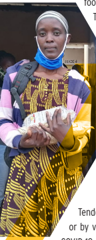

Document ID: 101
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The image contains text that appears to be a financial chart or graph, comparing two years, 2019 and 2020, for two categories: "International" and "Domestic." The numbers next to each category represent the values for those years. However, the specific details of the text are not clear enough to provide a precise explanation.
Image:


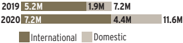

Document ID: 102
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The image contains a white letter "S" in the top left corner. It is stylized with a simple, clean font and is positioned against a white background. The text does not contain any additional information or context within the image. It is likely a logo or a part of a larger textual element not fully visible in the provided section of the image.
Image:


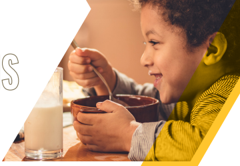

Document ID: 103
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The image contains text, which is the letter "A" in a stylized font. The text is positioned on the left side of the arrow, and its placement suggests it is part of a logo or a branding element. The text is designed to be simple and easily recognizable, which is a common practice in graphic design to ensure that the text is legible and memorable. The choice of a sans-serif font and the contrast between the text and the arrow's color are likely intended to convey a modern and clean aesthetic. The text does not provide any additional context within the image, so its purpose is not clear without further information.
Image:


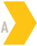

Document ID: 104
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The image contains text that provides information about a network of distribution sites. It lists various states across the United States, including Washington, Montana, Oregon, Idaho, Wyoming, Nevada, Utah, Colorado, California, Arizona, New Mexico, and Arizona again. Additionally, there is a specific mention of "Gilbert, AZ," which is likely the location of one of the distribution sites. The text "Remote Distribution Sites" suggests that the sites are not located in urban areas but are possibly set up in more remote locations to serve areas with limited infrastructure.
Image:


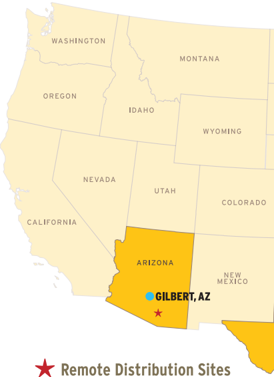

Document ID: 105
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image reads "KENYA" and "NAIROBI," which are the names of two countries and a city respectively. Kenya is a country located in East Africa, while Nairobi is the capital city of Kenya. The text is presented in a simple, sans-serif font, which is often used for its readability and modern appearance. There is no additional text visible in the image.
Image:


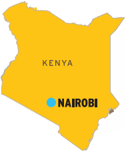

Document ID: 106
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image appears to be a list of domestic locations associated with the Midwest Food Bank, specifically the locations of its international locations. The text is presented in a list format with each location marked with a star, and the corresponding city is listed below each star. The text is not fully legible in the image provided, but it can be inferred that the locations are cities or regions where the Midwest Food Bank operates internationally, and the stars are used to visually represent these locations on the map. The text is likely intended to provide viewers with a quick reference to the locations of the Midwest Food Bank's international operations.
Image:


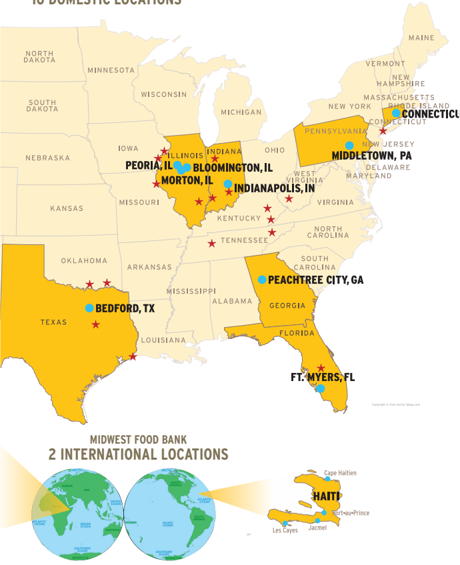

Document ID: 107
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The image does not contain any text. The focus is solely on the person wearing a face mask and the gesture of covering the face. The text in the image is not discernible due to the overlay of the yellow geometric shapes and the person's face. If there is text present, it is not within the visible frame of the image.
Image:


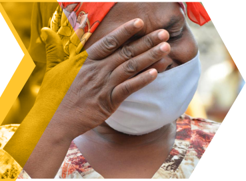

Document ID: 108
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The image does not contain any discernible text. It focuses on the individuals and their activity, with the background elements serving as context rather than a source of textual information. The absence of text allows the viewer to concentrate on the visual elements and the apparent narrative of aid distribution. If there were text, it would likely be related to the cause of the aid or the organization involved, but since there is no text visible, we cannot provide an explanation of any text within the image.
Image:


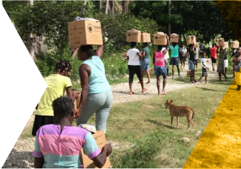

Document ID: 109
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The image itself does not contain any text. It is a photograph that focuses on the interaction between the two individuals and the context of the activity they are engaged in. If there were text within the image, it would likely provide context or information about the event, the individuals, or the organization involved. However, since there is no text present, it is not possible to provide an explanation of any text that might be in the image.
Image:


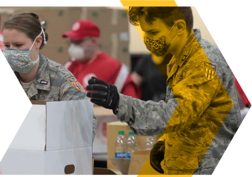

Document ID: 110
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is not clear enough to be transcribed accurately due to the resolution and angle of the photograph. It appears to be a logo or a symbol on the packaging, which is common in food packaging to indicate branding or origin. However, without a higher resolution or a closer view, it's not possible to provide a detailed explanation of the text. If the text is a logo or a brand name, it would typically be associated with the company that produced the product or the organization that distributed it. If it's a message or a slogan, it would likely be related to the context of the image, which seems to be a scene of food distribution or charity work.
Image:


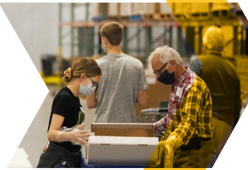

Document ID: 111
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image states, "In 2020, there were 450 volunteers for every 1 paid MFB staff member." This statement likely refers to the ratio of volunteers to paid staff members for a specific organization or initiative named MFB. Without additional context, it's not possible to determine the exact meaning of the text or the organization it pertains to. However, the number suggests a significant number of volunteers compared to paid staff members, which could imply a high level of community engagement or a substantial need for volunteers in that organization's operations.
Image:


Document ID: 112
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is not fully legible due to the angle and quality of the photograph. However, it appears to be related to the Midwest Food Bank, which is a charitable organization that provides food assistance to those in need. The visible text includes the words "Midwest Food Bank," which is part of the logo in the background. The text likely serves to identify the organization and possibly the event or activity the individuals are participating in, which could be a food bank distribution or a volunteer activity. Without a clearer view or additional context, it is not possible to provide a more detailed explanation of the text.
Image:


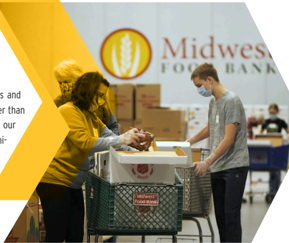

Document ID: 113
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image reads "MIDWEST FOOD BANK DISASTER RELIEF LOADS IN 2020." This suggests that the image is likely associated with a report or data visualization related to the efforts of a food bank in the Midwest region during the year 2020. The term "disaster relief" implies that the food bank was providing assistance to those affected by a disaster, which could have been a natural disaster, a pandemic, or another type of crisis. The presence of the box with the "Doing the Most Good" logo indicates that the food bank may have been a recipient of donations or support during this time. The map with the blue lines could represent the distribution of relief efforts or the reach of the food bank's services across different states.
Image:


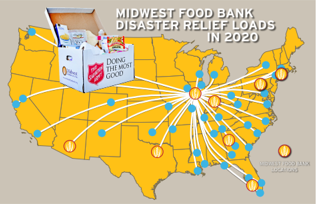

Document ID: 114
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The image contains no text.
Image:


Document ID: 115
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The image contains no text. It is a simple illustration of a hand holding a smartphone with a signal icon, which could symbolize various things such as connectivity, communication, or the availability of services. The absence of text allows the viewer to focus on the visual representation of the hand and the phone, without the distraction of written content.
Image:


Document ID: 116
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The image contains text that appears to be part of a logo or branding element, but it is not fully legible in the provided view. The visible text seems to be a stylized representation of the number "12," which could be part of a larger word or phrase that is not completely shown. Without the full context or additional information, it is not possible to accurately interpret the full text or its significance. If this text is part of a logo, it may represent the name of an organization, a company, or a specific campaign. However, without further information or a clearer view, providing a precise explanation of the text is not feasible.
Image:


Document ID: 117
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is partially obscured, and it appears to be a logo or a watermark. The visible part of the text reads "MAT," which could be an abbreviation or part of a larger word. Without additional context or a full view of the text, it is not possible to provide a definitive explanation of the text. If this is part of a larger image or document, further information would be needed to accurately determine the full text and its meaning.
Image:


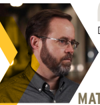

Document ID: 118
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is not entirely clear due to the resolution and angle of the photograph. However, it appears to be a logo or branding on the side of the truck, which is common for commercial vehicles to display their company identity. The text is likely the name or logo of the company operating the truck, which could be involved in transportation, logistics, or a similar industry. Without a clearer view or additional context, it is not possible to provide a precise transcription of the text.
Image:


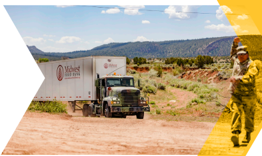

Document ID: 119
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is not legible; however, the pie chart is designed to represent the distribution of food sources and their contribution to the food supply chain. The pie chart is divided into four segments, each labeled with a different category of food sources. The largest segment is labeled "Food Manufacturers," accounting for 45% of the total, suggesting that this category is the largest contributor to the food supply. The next largest segment is "Food Distributors," at 37%, indicating that they are the second-largest contributors. The smallest segment is labeled "Other Local Grocery Runs, Food Drives, Other Donations," which makes up 5% of the total, highlighting that other local initiatives contribute the least to the food supply chain. The chart is a visual representation of the distribution of food sources, with the largest portion being from manufacturers, followed by distributors, and t

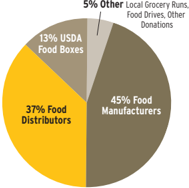

Document ID: 120
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The image does not contain any text. It is a simple illustration of a milk bottle and a glass, which are commonly associated with the consumption of milk. The absence of text in the image allows for a clear and unobstructed view of the objects, which are likely intended to represent the idea of dairy products or beverages in general.
Image:


Document ID: 121
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is not clearly visible due to the resolution and angle of the photograph. Therefore, it is not possible to provide a detailed explanation of the text from the image. If the text is essential for understanding the context or the items in the image, it would typically be found on the labels of the products, which are not legible in this image. To obtain the text, one would need a higher resolution image where the text is readable or additional information about the items shown.
Image:


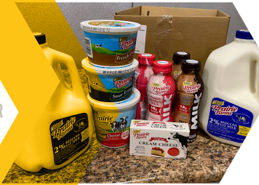

Document ID: 122
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The image contains text that reads "COMPARABLE ORGANIZATIONS" and "MIDWEST FOOD BANK". This text suggests that the image is likely a graphical representation of data comparing the financial contributions or impact of the Midwest Food Bank to comparable organizations. The text is positioned in a way that seems to be providing context or information about the data presented, possibly indicating that the Midwest Food Bank's contributions are being compared to those of other similar organizations. However, without additional context or data, it is not possible to determine the specific nature of the comparison or the significance of the percentages provided.
Image:


Document ID: 123
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is "Midwest FOOD BANK SHARE PARTNERS." This phrase indicates that the image is likely associated with a food bank organization that operates in the Midwest region. The term "share partners" suggests that the organization is involved in collaborations or partnerships with other entities, possibly other food banks or organizations, to share resources, information, or efforts related to food assistance. The presence of the wheat stalk in the logo could symbolize the organization's focus on food security and agriculture, which are central to the mission of food banks.
Image:


Document ID: 124
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image contains information about a charity's rating, specifically indicating that it has been recognized as a "Four Star Charity" by a certain entity or organization. The text is designed to convey a sense of trust and quality, suggesting that the charity has met certain standards or criteria set by the entity that awarded the rating. The use of stars is a common visual metaphor for rating systems, where each star typically represents a level of quality or excellence. In this context, the four stars could imply a high level of achievement or excellence in the field of charity.
Image:


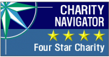

Document ID: 125
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is partially obscured and not fully legible. The visible letters appear to be part of a larger word or phrase, but due to the angle and resolution of the photograph, it is not possible to accurately decipher the text. The text seems to be in a serif font, which is often used in print and can be associated with formality or traditional print media. The text is not clear enough to provide a complete explanation without speculation.
Image:


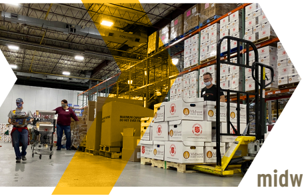

Document ID: 126
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is partially visible and appears to be related to the company "Midwest Food & Disaster Relief." The visible text includes "Food & Disaster Relief" and "Midwest," which suggests that the truck is part of a relief effort, possibly providing food or other essential supplies to areas affected by disasters. The text is not fully legible, but it is clear that the truck is associated with a charitable or humanitarian organization that operates in the Midwest region.
Image:


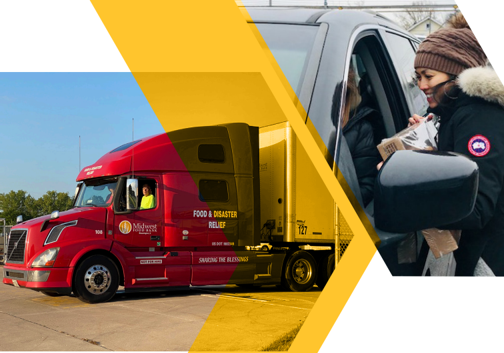

Document ID: 127
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The image contains text, but it is partially obscured and not entirely legible. The visible text on the man's shirt reads "TEAM RUBICON," which is a nonprofit organization that provides disaster relief and support to communities affected by natural disasters. The text is clear and legible, indicating the man is likely involved in an event or activity organized by this organization. The text on the box he is holding is also visible, but the specific details are not discernible from the image provided.
Image:


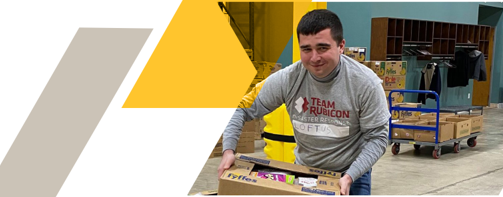

Document ID: 128
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is a logo for the Midwest Food Bank, which is an organization that likely provides food assistance to individuals and families in the Midwest region. The logo includes the name of the organization and its website, which are essential for branding and directing potential supporters to the organization's official site for more information. The use of a wheat stalk in the logo symbolizes the food bank's focus on providing grains, which is a staple food item. The color scheme of red and yellow may be chosen to evoke warmth and energy, which could be intended to inspire positive action and community support for the organization's mission.
Image:


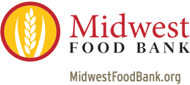

In [11]:
import itertools
from docling_core.types.doc.document import RefItem
from IPython.display import display

# Print all created documents
for document in itertools.chain(texts, tables):
    print(f"Document ID: {document.metadata['doc_id']}")
    print(f"Source: {document.metadata['source']}")
    print(f"Content:\n{document.page_content}")
    print("=" * 80)  # Separator for clarity

for document in pictures:
    print(f"Document ID: {document.metadata['doc_id']}")
    source = document.metadata['source']
    print(f"Source: {source}")
    print(f"Content:\n{document.page_content}")
    docling_document = conversions[source]
    ref = document.metadata['ref']
    picture = RefItem(cref=ref).resolve(docling_document)
    image = picture.get_image(docling_document)
    print("Image:")
    display(image)
    print("=" * 80)  # Separator for clarity


## Populate the vector database

Using the embedding model, we load the documents from the text chunks and generated image captioning into a vector database. Creating this vector database allows us to easily conduct a semantic similarity search across our documents.

NOTE: Population of the vector database can take some time depending on your embedding model and service.

### Choose your vector database

Specify the database to use for storing and retrieving embedding vectors.

To connect to a vector database other than Milvus, replace this code cell with one from [this Vector Store recipe](https://github.com/ibm-granite-community/granite-kitchen/blob/main/recipes/Components/Langchain_Vector_Stores.ipynb).

In [12]:
import tempfile
from langchain_core.vectorstores import VectorStore
from langchain_milvus import Milvus

db_file = tempfile.NamedTemporaryFile(prefix="vectorstore_", suffix=".db", delete=False).name
print(f"The vector database will be saved to {db_file}")

vector_db: VectorStore = Milvus(
    embedding_function=embeddings_model,
    connection_args={"uri": db_file},
    auto_id=True,
    enable_dynamic_field=True,
    index_params={"index_type": "AUTOINDEX"},
)

The vector database will be saved to /tmp/vectorstore_dgfx7229.db


2025-06-19 01:28:18,297 [DEBUG][_create_connection]: Created new connection using: afdeee2e222e42ba954954238b32316e (async_milvus_client.py:599)


We now add all the LangChain documents for the text, tables and image descriptions to the vector database.

In [13]:
import itertools

documents = list(itertools.chain(texts, tables, pictures))
ids = vector_db.add_documents(documents)
print(f"{len(ids)} documents added to the vector database")

128 documents added to the vector database


## Step 5: RAG with Granite

Now that we have successfully converted our documents and vectorized them, we can set up out RAG pipeline.

### Retrieve relevant chunks



Here we test the vector database by searching for chunks with relevant information to our query in the vector space. We display the documents associated with the retrieved image description.

Feel free to try different queries.

In [14]:
query = "How much was spent on food distribution relative to the amount of food distributed?"
for doc in vector_db.as_retriever().invoke(query):
    print(doc)
    print("=" * 80)  # Separator for clarity

page_content='The image contains text that appears to be a comparative statement. It states that $13 million was spent and $383 million was yielded from food distribution. This suggests a high level of efficiency or impact in the distribution of food, where the yield far exceeds the expenditure. The text is likely used to highlight the effectiveness of a food distribution program or campaign.' metadata={'doc_id': 96, 'source': 'https://midwestfoodbank.org/images/AR_2020_WEB2.pdf', 'ref': '#/pictures/21', 'pk': 458829729339801695}
page_content='Midwest Food Bank Growth Value of food distributed (millions) Value of food distributed (millions)
2003    2004   2005   2006   2007    2008   2009    2010    2011    2012    2013    2014    2015    2016   2017   2018   2019   2020' metadata={'doc_id': 18, 'source': 'https://midwestfoodbank.org/images/AR_2020_WEB2.pdf', 'ref': '#/texts/177 #/texts/178', 'pk': 458829729339801617}
page_content='We  receive  donated  food  from  all  over  the count

The returned document should be responsive to the query. Let's go ahead and construct our RAG pipeline.

### Create the RAG pipeline for Granite

First we create the prompts for Granite to perform the RAG query. We use the Granite chat template and supply the placeholder values that the LangChain RAG pipeline will replace.

`{context}` will hold the retrieved chunks, as shown in the previous search, and feeds this to the model as document context for answering our question.

Next, we construct the RAG pipeline by using the Granite prompt templates previously created.


In [15]:
from ibm_granite_community.notebook_utils import escape_f_string
from langchain.prompts import PromptTemplate
from langchain.chains.retrieval import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain

# Create a Granite prompt for question-answering with the retrieved context
prompt = tokenizer.apply_chat_template(
    conversation=[{
        "role": "user",
        "content": "{input}",
    }],
    documents=[{
        "doc_id": "0",
        "text": "{context}",
    }],
    add_generation_prompt=True,
    tokenize=False,
)

# The Granite prompt can contain JSON strings, so we must escape them
prompt_template = PromptTemplate.from_template(template=escape_f_string(prompt, "input", "context"))

# Create a Granite document prompt template to wrap each retrieved document
document_prompt_template = PromptTemplate.from_template(template="""\
<|end_of_text|>
<|start_of_role|>document {{"document_id": "{doc_id}"}}<|end_of_role|>
{page_content}""")
document_separator=""

# Assemble the retrieval-augmented generation chain
combine_docs_chain = create_stuff_documents_chain(
    llm=model,
    prompt=prompt_template,
    document_prompt=document_prompt_template,
    document_separator=document_separator,
)
rag_chain = create_retrieval_chain(
    retriever=vector_db.as_retriever(),
    combine_docs_chain=combine_docs_chain,
)

### Generate a retrieval-augmented response to a question

The pipeline uses the query to locate documents from the vector database and use them as context for the query.

In [16]:
outputs = rag_chain.invoke({"input": query})

print(outputs['answer'])

The text provides a comparative statement suggesting a high level of efficiency in food distribution, with $13 million spent yielding $383 million worth of distributed food {"document_id": "0"}. However, the exact ratio of expenditure to food value is not specified in the document. It only indicates that the yield significantly exceeds the expenditure, implying a high level of efficiency. For precise figures, additional context or data would be necessary. Based on the given information, the expenditure seems to be a small fraction of the food distributed.


Awesome! We have created an AI application that can successfully leverage knowledge from the source documents' text and images.

## Next Steps

- Explore advanced RAG workflows for other industries.
- Experiment with other document types and larger datasets.
- Optimize prompt engineering for better Granite responses.

Thank you for using this recipe!